In [1]:
from google.colab import drive
import sys

drive.mount('/content/gdrive')
gdrive_path = "/content/gdrive/MyDrive/AIM/"
sys.path.append(gdrive_path)
!ls -l /content/gdrive/MyDrive/AIM/citizen*.txt
import aim_util

Mounted at /content/gdrive
-rw------- 1 root root 2696 Apr 15 14:07 /content/gdrive/MyDrive/AIM/citizen_1864_20240414_213308040_groundtruth.txt
-rw------- 1 root root 2696 May  2 20:40 /content/gdrive/MyDrive/AIM/citizen_1864_groundtruth_annotated.txt
-rw------- 1 root root 3899 May 22 18:53 /content/gdrive/MyDrive/AIM/citizen_1864_groundtruth_word_list_lower.txt
-rw------- 1 root root 3899 May 22 18:53 /content/gdrive/MyDrive/AIM/citizen_1864_groundtruth_word_list.txt
-rw------- 1 root root 3899 May 22 18:53 /content/gdrive/MyDrive/AIM/citizen_1864_groundtruth_word_string_lower.txt
-rw------- 1 root root 3899 May 22 18:53 /content/gdrive/MyDrive/AIM/citizen_1864_groundtruth_word_string.txt
-rw------- 1 root root   37 May 27 19:59 /content/gdrive/MyDrive/AIM/citizen_1864_xform0_carlv_word_list.txt
-rw------- 1 root root   25 May 27 19:59 /content/gdrive/MyDrive/AIM/citizen_1864_xform0_carlv_word_string.txt
-rw------- 1 root root 3796 May 24 19:19 /content/gdrive/MyDrive/AIM/citizen_186

In [2]:
!pip install keras_ocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 614.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.0 MB/s eta 0:00:00


In [3]:
import keras_ocr
import math
import aim_scanner

In [4]:
#!cat /content/gdrive/MyDrive/AIM/aim_scanner.py

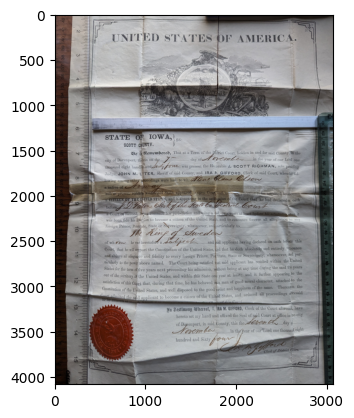

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/gdrive/MyDrive/AIM/citizen_1864_rescan.jpg'

img = mpimg.imread(image_path)
plt.imshow(img)

In [5]:
# obtain keras OCR pipeine
pipeline_OCR = aim_scanner.get_pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


Looking for /root/.keras-ocr/crnn_kurapan.h5


In [6]:
def Detect(image_path,pipeline):
    """OCR for text detection"""


    # Read in image path
    read_image = keras_ocr.tools.read(image_path)
    # prediction_groups is a list of (word, box) tuples
    prediction_groups = pipeline.recognize([read_image])
    return prediction_groups[0]

In [7]:
def Distance(predictions):
    """
    Returns dictionary with (key,value):

    """

    # Point of origin
    x0, y0 = 0, 0
    # Generate dictionary
    detections = []
    for group in predictions:

        # Get center point of bounding box
      top_left_x, top_left_y = group[1][0]
      bottom_right_x, bottom_right_y = group[1][1]
      center_x = (top_left_x + bottom_right_x) / 2
      center_y = (top_left_y + bottom_right_y) / 2
      # Use the Pythagorean Theorem to solve for distance from origin
      distance_from_origin = math.dist([x0,y0], [center_x, center_y])
      # Calculate difference between y and origin to get unique rows
      distance_y = center_y - y0
      # Append all results
      detections.append({
                          'text':group[0],
                          'center_x':center_x,
                          'center_y':center_y,
                          'distance_from_origin':distance_from_origin,
                          'distance_y':distance_y,
                          'top_left_x': top_left_x,
                          'top_left_y': top_left_y,
                          'bottom_right_x': bottom_right_x,
                          'bottom_right_y': bottom_right_y,
                      })
    return detections

In [8]:
def distinguish_rows(lst, thresh):
    """Function to help distinguish unique rows"""

    sublists = []
    for i in range(0, len(lst)-1):
        if lst[i+1]['distance_y'] - lst[i]['distance_y'] <= thresh:
            if lst[i] not in sublists:
                sublists.append(lst[i])
            sublists.append(lst[i+1])
        else:
            yield sublists
            sublists = [lst[i+1]]
    yield sublists

In [31]:
def OCR(image_path, pipeline, order='yes',thresh=6):
    """
    Function returns predictions in human readable order
    from left to right & top to bottom
    """
    ordered_word_list = []
    ordered_word_list_with_newline = []

    predictions_raw = Detect(image_path, pipeline)
    #print(f"predictions (raw)->{predictions_raw}")
    predictions_2 = Distance(predictions_raw)
    #print(f"predictions_2->{predictions_2}")
    longitud=len(predictions_2)
    if longitud==1:
        ordered_word_string = predictions_2[0]['text']
    else:

        predictions_3 = list(distinguish_rows(predictions_2, thresh))
        #print(f"predictions_3->{predictions_3}")
        # Remove all empty rows
        predictions_3_f = list(filter(lambda x:x!=[], predictions_3))
        #print(f"predictions_3_f->{predictions_3_f}")
        # Order text detections in human readable format

        pred_sort_dist = []
        #breakout = False
        ylst = ['yes', 'y']
        for pr in predictions_3_f:
            #print(f"pr->{pr}")
            if order in ylst:
                row = sorted(pr, key=lambda x:x['distance_from_origin'])
                #print(f"sorted row->{row}")
                for each in row:
                    ordered_word_list.append(each['text'])
                    ordered_word_list_with_newline.append(each['text'])
                    #print(f"each->{each}, each-text->{each['text']}")

                    # append bbox preds
                    pred_sort_dist.append([each['text'], each['center_x'],each['center_y'],each['distance_from_origin'],each['distance_y'],each['top_left_x'],each['top_left_y'],each['bottom_right_x'],each['bottom_right_y']])

                ordered_word_list_with_newline.append("\n")
                # breakout = True
                # if breakout:
                #     break
        #print(pred_sort_dist)
        #print(f"ordered_word_string->{ordered_word_string}")

    print(f"ordered_word_list->{ordered_word_list}")
    print(f"ordered_word_list_with_newline->{ordered_word_list_with_newline}")

    # with open('texto.txt','a+') as f:
    #     for word in ordered_word_list:
    #         f.write(word + ' ')
    # word_list = ''
    ordered_word_string = ""
    ordered_word_string_with_newline =""
    for word in ordered_word_list:
        ordered_word_string = ordered_word_string + ' ' + word
    for word in ordered_word_list_with_newline:
        ordered_word_string_with_newline = ordered_word_string_with_newline + ' ' + word

    #print(f"ordered_preds_with_newline->{ordered_preds_with_newline}")
    return predictions_raw, pred_sort_dist, ordered_word_string, ordered_word_string_with_newline, ordered_word_list

In [32]:
import pickle
import numpy as np
import pandas as pd

def pred_to_pd(predictions, raw=True):
    data_list = []

    if raw:
        for word, coords in predictions:
            upper_left_X, upper_left_Y, lower_left_X, lower_left_Y, lower_right_X, lower_right_Y, upper_right_X, upper_right_Y = coords.flatten()
            data_list.append([word, upper_left_X, upper_left_Y, lower_left_X, lower_left_Y, lower_right_X, lower_right_Y, upper_right_X, upper_right_Y])

        df = pd.DataFrame(data_list, columns=['word', 'UL_X', 'UL_Y', 'LL_X', 'LL_Y', 'LR_X', 'LR_Y', 'UR_X', 'UR_Y'])
        df = df.astype({col: np.float32 for col in df.columns[1:]})
    else:
        for word, center_x, center_y, distance_from_origin, distance_y, top_left_x, top_left_y, bottom_right_x, bottom_right_y in predictions:
            data_list.append([word, center_x, center_y, distance_from_origin, distance_y, top_left_x, top_left_y, bottom_right_x, bottom_right_y])

        df = pd.DataFrame(data_list, columns=['word', 'CENTER_X', 'CENTER_Y', 'DIST_ORIGEN', 'DIST_Y', 'UL_X', 'UL_Y', 'LR_X', 'LR_Y'])
        df = df.astype({col: np.float32 for col in df.columns[1:]})

    print(df.head())
    return df

#def write_preds_fileset(predictions, ordered_preds, word_preds, gdrive_path, base_name):
def write_preds_fileset(predictions_raw, pred_sort_dist, ordered_word_string, ordered_word_string_with_newline, word_list, gdrive_path, base_name):

    pred_raw_df = pred_to_pd(predictions_raw, raw=True)
    pickle_path = gdrive_path + base_name + "_raw_bbox.pkl"
    aim_scanner.write_to_pickle(pred_raw_df, pickle_path)

    pred_sort_dist_df = pred_to_pd(pred_sort_dist, raw=False)
    pickle_path = gdrive_path + base_name + "_sort_dist_bbox.pkl"
    aim_scanner.write_to_pickle(pred_sort_dist_df, pickle_path)

    aim_util.write_text(ordered_word_string, gdrive_path + base_name + "_word_string.txt")
    aim_util.write_text(ordered_word_string_with_newline, gdrive_path + base_name + "_newline_word_string.txt")
    aim_util.write_text(str(word_list), gdrive_path + base_name + "_word_list.txt")


15/15 [==============================] - 127s 8s/step
ordered_word_list->['united', 'states', 'of', 'america', 'luere', 'ralling', 'o', 'o', 'v', 'state', 'of', 'iowa', 'sss', 'co', 'scott', 'cunty', 'be', 'it', 'renteutbeted', 'that', 'at', 'e', 'term', 'or', 'the', 'district', 'court', 'holden', 'n', 'and', 'for', 'said', 'county', 'n', 'the', 'e', 'ovcm', 'elc', 'city', 'of', 'davenport', 'theein', 'on', 'the', 'day', 'of', 'in', 'the', 'year', 'of', 'our', 'lord', 'one', 'o', 'susty', 'thousand', 'eight', 'hundre', 'and', 'fuw', 'was', 'present', 'the', 'hororable', 'je', 'scott', 'richmany', 'sole', 'prsiding', 'judge', 'john', 'me', 'lyter', 'sheriff', 'of', 'said', 'county', 'and', 'ira', 't', 'gifford', 'clerk', 'of', 'said', 'court', 'whenthe', 'fol', 'v', 'anws', 'cans', 'olen', 'lowing', 'among', 'other', 'roceedings', 'were', 'had', 'towits', 's', 'a', 'native', 'of', 'a', 'loc', 'prcsens', 'resian', 'vltmm', 'said', 'stater', 'appeared', 'lile', 'open', 'cout', 'icctolente

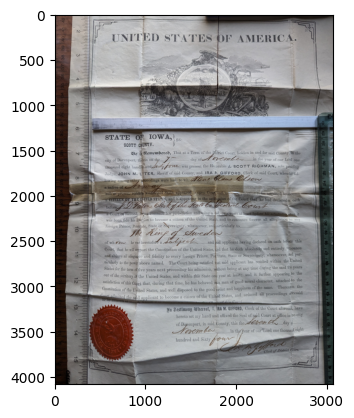

In [33]:
%%time
base_name = 'citizen_1864_xform0_carlv'
image_path = '/content/gdrive/MyDrive/AIM/citizen_1864_rescan.jpg'
img = mpimg.imread(image_path)
plt.imshow(img)

#predictions, ordered_preds, word_preds = aim_scanner.OCR(image_path, pipeline_OCR, order='yes', thresh=16)
#predictions, ordered_preds, word_preds = OCR(image_path, pipeline_OCR, order='yes', thresh=16)
predictions_raw, pred_sort_dist, ordered_word_string, ordered_word_string_with_newline, word_list = OCR(image_path, pipeline_OCR, order='yes', thresh=16)

#aim_scanner.write_preds_fileset(predictions_raw, ordered_word_string, word_list, gdrive_path, base_name)

In [34]:
write_preds_fileset(predictions_raw, pred_sort_dist, ordered_word_string, ordered_word_string_with_newline, word_list, gdrive_path, base_name)

      word         UL_X        UL_Y         LL_X        LL_Y         LR_X  \
0        c    75.703125   39.843750   111.562500   39.843750   111.562500   
1   united   628.225586  214.346313  1150.899780  204.390610  1152.918457   
2   states  1207.265625  219.140625  1741.171875  219.140625  1741.171875   
3  america  2018.740723  227.915924  2668.840332  216.306961  2670.604736   
4       of  1785.000000  223.125000  1956.328125  223.125000  1956.328125   

         LR_Y         UR_X        UR_Y  
0   91.640625    75.703125   91.640625  
1  310.374451   630.244263  320.330170  
2  318.750000  1207.265625  318.750000  
3  315.102203  2020.504883  326.711151  
4  322.734375  1785.000000  322.734375  
Dataframe successfully written to: /content/gdrive/MyDrive/AIM/citizen_1864_xform0_carlv_raw_bbox.pkl
      word     CENTER_X    CENTER_Y  DIST_ORIGEN      DIST_Y         UL_X  \
0   united   889.562683  209.368469   913.869202  209.368469   628.225586   
1   states  1474.218750  219.140625

In [35]:
#print(str(word_list))

['united', 'states', 'of', 'america', 'luere', 'ralling', 'o', 'o', 'v', 'state', 'of', 'iowa', 'sss', 'co', 'scott', 'cunty', 'be', 'it', 'renteutbeted', 'that', 'at', 'e', 'term', 'or', 'the', 'district', 'court', 'holden', 'n', 'and', 'for', 'said', 'county', 'n', 'the', 'e', 'ovcm', 'elc', 'city', 'of', 'davenport', 'theein', 'on', 'the', 'day', 'of', 'in', 'the', 'year', 'of', 'our', 'lord', 'one', 'o', 'susty', 'thousand', 'eight', 'hundre', 'and', 'fuw', 'was', 'present', 'the', 'hororable', 'je', 'scott', 'richmany', 'sole', 'prsiding', 'judge', 'john', 'me', 'lyter', 'sheriff', 'of', 'said', 'county', 'and', 'ira', 't', 'gifford', 'clerk', 'of', 'said', 'court', 'whenthe', 'fol', 'v', 'anws', 'cans', 'olen', 'lowing', 'among', 'other', 'roceedings', 'were', 'had', 'towits', 's', 'a', 'native', 'of', 'a', 'loc', 'prcsens', 'resian', 'vltmm', 'said', 'stater', 'appeared', 'lile', 'open', 'cout', 'icctolente', 'be', 'aemitted', 'oeceme', 'v', 'a', 'citizen', 'of', 'thie', 'uited'

In [41]:
def test_preds_to_pickle(predictions, raw, gdrive_path, base_name):
    preds_df = pred_to_pd(predictions, raw)
    print(f"gen preds->{preds_df.head()}")

    pickle_path = gdrive_path + base_name + "_bbox.pkl"

    preds_read_df = aim_scanner.read_from_pickle(pickle_path)
    print(f"read preds->{preds_read_df.head()}")

    # Compare the two dataframes
    result = preds_df.equals(preds_read_df)
    print("Result of comparison:", result)


In [42]:
#aim_scanner.test_preds_to_pickle(predictions, gdrive_path, base_name)
base_name = "citizen_1864_xform0_carlv_raw"
test_preds_to_pickle(predictions_raw, True, gdrive_path, base_name)
base_name = "citizen_1864_xform0_carlv_sort_dist"
test_preds_to_pickle(pred_sort_dist, False, gdrive_path, base_name)

      word         UL_X        UL_Y         LL_X        LL_Y         LR_X  \
0        c    75.703125   39.843750   111.562500   39.843750   111.562500   
1   united   628.225586  214.346313  1150.899780  204.390610  1152.918457   
2   states  1207.265625  219.140625  1741.171875  219.140625  1741.171875   
3  america  2018.740723  227.915924  2668.840332  216.306961  2670.604736   
4       of  1785.000000  223.125000  1956.328125  223.125000  1956.328125   

         LR_Y         UR_X        UR_Y  
0   91.640625    75.703125   91.640625  
1  310.374451   630.244263  320.330170  
2  318.750000  1207.265625  318.750000  
3  315.102203  2020.504883  326.711151  
4  322.734375  1785.000000  322.734375  
gen preds->      word         UL_X        UL_Y         LL_X        LL_Y         LR_X  \
0        c    75.703125   39.843750   111.562500   39.843750   111.562500   
1   united   628.225586  214.346313  1150.899780  204.390610  1152.918457   
2   states  1207.265625  219.140625  1741.171875 

In [ ]:
%%time
base_name = 'citizen_1864_xform1_carlv'
image_path = '/content/gdrive/MyDrive/AIM/citizen_xform1.jpg'
aim_util.show_image(image_path)

predictions, ordered_preds, word_preds = aim_scanner.OCR(image_path, pipeline_OCR, order='yes', thresh=16)

aim_scanner.write_preds_fileset(predictions, ordered_preds, word_preds, gdrive_path, base_name)

12/12 [==============================] - 84s 7s/step
Text string of 3044 bytes successfully written to /content/gdrive/MyDrive/AIM/citizen_1864_xform2_carlv_word_list.txt.
Text string of 1985 bytes successfully written to /content/gdrive/MyDrive/AIM/citizen_1864_xform2_carlv_word_string.txt.
Dataframe successfully written to: /content/gdrive/MyDrive/AIM/citizen_1864_xform2_carlv_bbox.pkl
CPU times: user 3min 21s, sys: 14.3 s, total: 3min 35s
Wall time: 3min 48s


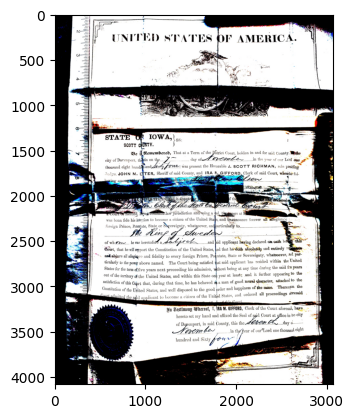

In [11]:
%%time
base_name = 'citizen_1864_xform2_carlv'
image_path = '/content/gdrive/MyDrive/AIM/citizen_xform2.jpg'
aim_util.show_image(image_path)

predictions, ordered_preds, word_preds = aim_scanner.OCR(image_path, pipeline_OCR, order='yes', thresh=16)

aim_scanner.write_preds_fileset(predictions, ordered_preds, word_preds, gdrive_path, base_name)

15/15 [==============================] - 110s 7s/step
Text string of 3770 bytes successfully written to /content/gdrive/MyDrive/AIM/citizen_1864_xform3_carlv_word_list.txt.
Text string of 2396 bytes successfully written to /content/gdrive/MyDrive/AIM/citizen_1864_xform3_carlv_word_string.txt.
Dataframe successfully written to: /content/gdrive/MyDrive/AIM/citizen_1864_xform3_carlv_bbox.pkl
CPU times: user 4min 1s, sys: 17 s, total: 4min 18s
Wall time: 3min 18s


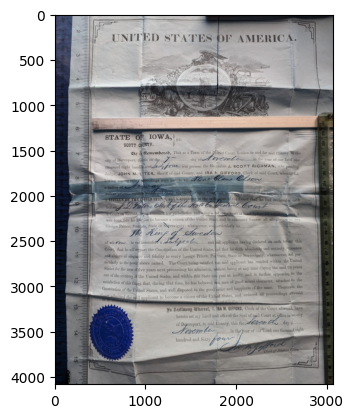

In [12]:
%%time
base_name = 'citizen_1864_xform3_carlv'
image_path = '/content/gdrive/MyDrive/AIM/citizen_xform3.jpg'
aim_util.show_image(image_path)

predictions, ordered_preds, word_preds = aim_scanner.OCR(image_path, pipeline_OCR, order='yes', thresh=16)

aim_scanner.write_preds_fileset(predictions, ordered_preds, word_preds, gdrive_path, base_name)

10/10 [==============================] - 70s 7s/step
Text string of 2450 bytes successfully written to /content/gdrive/MyDrive/AIM/citizen_1864_xform4_carlv_word_list.txt.
Text string of 1583 bytes successfully written to /content/gdrive/MyDrive/AIM/citizen_1864_xform4_carlv_word_string.txt.
Dataframe successfully written to: /content/gdrive/MyDrive/AIM/citizen_1864_xform4_carlv_bbox.pkl
CPU times: user 2min 56s, sys: 14.7 s, total: 3min 11s
Wall time: 2min 13s


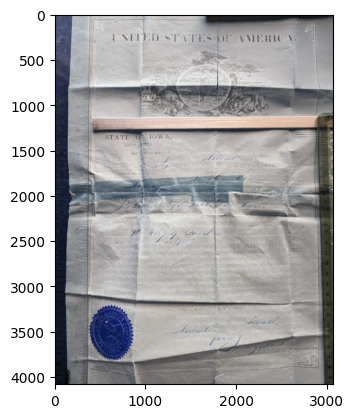

In [13]:
%%time
base_name = 'citizen_1864_xform4_carlv'
image_path = '/content/gdrive/MyDrive/AIM/citizen_xform4.jpg'
aim_util.show_image(image_path)

predictions, ordered_preds, word_preds = aim_scanner.OCR(image_path, pipeline_OCR, order='yes', thresh=16)

aim_scanner.write_preds_fileset(predictions, ordered_preds, word_preds, gdrive_path, base_name)

15/15 [==============================] - 110s 7s/step
Text string of 3809 bytes successfully written to /content/gdrive/MyDrive/AIM/citizen_1864_xform5_carlv_word_list.txt.
Text string of 2432 bytes successfully written to /content/gdrive/MyDrive/AIM/citizen_1864_xform5_carlv_word_string.txt.
Dataframe successfully written to: /content/gdrive/MyDrive/AIM/citizen_1864_xform5_carlv_bbox.pkl
CPU times: user 4min 1s, sys: 16.3 s, total: 4min 17s
Wall time: 3min 17s


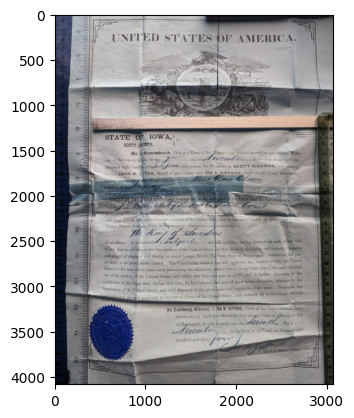

In [14]:
%%time
base_name = 'citizen_1864_xform5_carlv'
image_path = '/content/gdrive/MyDrive/AIM/citizen_xform5.jpg'
aim_util.show_image(image_path)

predictions, ordered_preds, word_preds = aim_scanner.OCR(image_path, pipeline_OCR, order='yes', thresh=16)

aim_scanner.write_preds_fileset(predictions, ordered_preds, word_preds, gdrive_path, base_name)

In [15]:
#####################################################################################################